In [1]:
import gym
import numpy as np
import random
import torch


In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [166]:
class Memory():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.short_memory = []
        
    def push(self, old_state, action, reward, new_state):
        self.short_memory.append([old_state, action, reward, new_state, False])
        
    def commit(self, final=True): 
        
        self.short_memory[-1][-1] = final
        
# #         discount
#         for i, memo in enumerate(self.short_memory[::-1]):
#             old_state, action, reward, new_state, *_ = memo
            
#             if i == 0:
#                 prev_reward = reward
#                 continue
                
#             reward, prev_reward = prev_reward * 0.99 + reward, reward
#             self.short_memory[len(self.short_memory) - 1 - i][2] = reward 
            
        self.short_memory = [x for x in self.short_memory if x[-1] == False]
        
        if len(self.memory) + len(self.short_memory) < self.capacity:
            self.memory.extend(self.short_memory)
        else:
            for memo in self.short_memory:
                self.memory.insert(0, memo)
        
        self.short_memory = []

In [167]:
model = torch.nn.Sequential(
    torch.nn.Linear(4, 8),
    torch.nn.LeakyReLU(inplace=True),
#     torch.nn.Linear(32, 32),
#     torch.nn.LeakyReLU(inplace=True),
    torch.nn.Linear(8, 2),
#     torch.nn.Sigmoid(),
#     torch.nn.Softmax(dim=1),
)

model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.1)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=30, gamma=0.97)

In [195]:
class Qnet(torch.nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(4, 8),
            torch.nn.LeakyReLU(inplace=True),
        #     torch.nn.Linear(32, 32),
        #     torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(8, 2),
#             torch.nn.Sigmoid(),
        #     torch.nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        return self.model(x)

policy_net = Qnet().to(device)
target_net = Qnet().to(device)

target_net.load_state_dict(policy_net.state_dict())

optim = torch.optim.Adam(policy_net.parameters(), lr=0.05)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=30, gamma=0.97)    

In [197]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 2000

STEP = 0
EPS = 0.8
EPS_MIN = 0.05
GAMMA = 0.9999


def get_model_action(model, state, device, train=True):
    global STEP, EPS, EPS_MIN, GAMMA
    STEP += 1
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
    if not train or random.random() > EPS:
        with torch.no_grad():
            model_output = model(torch.FloatTensor(state).to(device).unsqueeze(0)).cpu().detach().numpy()
            action = np.argmax(model_output[0])
    else:
        action = random.randint(0, 1)
    return action

def train(model, memory, device):
    memory = memory.memory
    np.random.shuffle(memory)
    memory = memory[:512]
    
    old = [x[0] for x in memory]
    actions = [[x[1]] for x in memory]
    rewards = [x[2] for x in memory]
    new = [x[3] for x in memory]
    
    old = torch.FloatTensor(old).to(device)
    new = torch.FloatTensor(new).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    actions = torch.LongTensor(actions).to(device)
    
#     print(old)
#     print(new)
#     print(rewards)
#     print(actions)
    
    
    state_action_values = policy_net(old).gather(1, actions)
    next_state_values = target_net(new).max(1)[0].detach()
    expected_state_action_values = (next_state_values * 0.999) + rewards
#     print('next', next_state_values)
#     print('rew', rewards)
#     print('exp', expected_state_action_values)
#     assert False
    loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    policy_net.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optim.step()

#     train_data = []
#     for memo in memory:
#         old_state, action, reward, new_state, *_ = memo
        
#         state_value = policy_net(torch.FloatTensor(old_state).to(device).unsqueeze(0)).cpu().detach().numpy()
#         state_value = np.argmax(state_value)
        
#         expected = target_net(torch.FloatTensor(new_state).to(device).unsqueeze(0)).cpu().detach().numpy()
#         expected = np.argmax(expected[0])
#         expected = expected * 0.96 + reward
        
        
        
#         train_data.append([state_value, expected])
        
#     batch_size = 1024
#     np.random.shuffle(train_data)
    
#     for i in range((len(train_data) // batch_size)):
#         policy_net.zero_grad()
        
#         data = train_data[i*batch_size : i*batch_size + batch_size]
#         x, y = [x[0] for x in data], [x[1] for x in data]
#         x = torch.FloatTensor(x).to(device)
#         y = torch.FloatTensor(x).to(device)
# #         output = model(torch.FloatTensor(x).to(device))
# #         loss = torch.nn.functional.l1_loss(output, torch.FloatTensor(y).to(device))
#         loss = torch.nn.functional.smooth_l1_loss(x, y)
#         loss.backward()
#         optim.step()
        
    scheduler.step()

memory = Memory(capacity=10000)

#get starting actions
# for episode in range(100):
#     state = env.reset()
#     for i in range(100):
#         action = env.action_space.sample()
#         old_state = state
#         state, reward, done, info = env.step(action)
        
#         memory.push(old_state, action, reward, state)
#         state = old_state
#         if done:
#             env.close()
#             break
#     memory.commit()
        

from itertools import count

len_mem = []
try:
    for episode in range(10000):
        state = env.reset()

        for i in count():
#             env.render()

            action = get_model_action(policy_net, state, device)
            old_state = state
            state, reward, done, info = env.step(action)
            
            memory.push(old_state, action, reward, state)
            state = old_state

            if done:
                env.close()
                len_mem.append(i)
                memory.commit(final=i!=2000)
                break

        
        if episode % 50 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(len_mem[-20:]), EPS))
        
        train(policy_net, memory, device)
        
        if episode % 1 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
    
except KeyboardInterrupt:
    env.close()

Episode   0:     14.000 iterations, eps=0.798801
Episode  50:     16.600 iterations, eps=0.727713
Episode 100:     14.900 iterations, eps=0.664744
Episode 150:     14.000 iterations, eps=0.616217
Episode 200:     14.350 iterations, eps=0.569577
Episode 250:     12.100 iterations, eps=0.528261
Episode 300:     11.600 iterations, eps=0.491758
Episode 350:     11.150 iterations, eps=0.458511
Episode 400:     11.700 iterations, eps=0.428410
Episode 450:     11.650 iterations, eps=0.404106
Episode 500:     11.150 iterations, eps=0.380914
Episode 550:     10.650 iterations, eps=0.358910


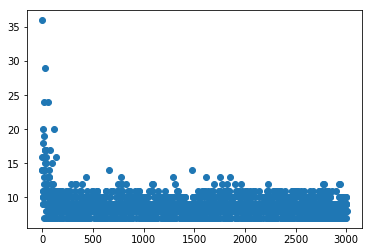

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(len_mem, 'o')

In [91]:
try:
    env.seed = random.randint(0, 100000)
    obs = env.reset()
    env._max_episode_steps = 5000
    for t in count():
        env.render()
        action = get_model_action(model, obs, device, train=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print(t)

63
63


In [49]:
model.to('cpu')

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=8, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)

In [50]:
torch.save(model, 'model.torch')

In [51]:
model = torch.load('model.torch')

In [52]:
model.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=8, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)